In [2]:
pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 5.6 MB/s 
     |████████████████████████████████| 3.5 MB 28.5 MB/s 
     |████████████████████████████████| 1.2 MB 23.1 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
     |████████████████████████████████| 895 kB 41.8 MB/s 
     |████████████████████████████████| 596 kB 43.8 MB/s 
     |████████████████████████████████| 6.8 MB 40.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=7b0ecd9b749d07fb956b8f31d89137781a395868aa9118558ffbf33ce692ab42
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
from platform import python_version
print(python_version())

3.7.12


# Data Preprocessing

In [4]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [5]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import re
import string
import numpy as np

In [5]:
df1=pd.read_csv("/content/drive/My Drive/Colab Notebooks/reviews202108.csv",encoding='utf-16')
df2=pd.read_csv("/content/drive/My Drive/Colab Notebooks/reviews202109.csv",encoding='utf-16')
df3=pd.read_csv("/content/drive/My Drive/Colab Notebooks/reviews202110.csv",encoding='utf-16')
df4=pd.read_csv("/content/drive/My Drive/Colab Notebooks/reviews202111.csv",encoding='utf-16')
df5=pd.read_csv("/content/drive/My Drive/Colab Notebooks/reviews202112.csv",encoding='utf-16')
df6=pd.read_csv("/content/drive/My Drive/Colab Notebooks/reviews202201.csv",encoding='utf-16')

def adding_key(data,date):
  data['key']=np.arange(1, len(data)+1)
  data['date']=date
  return data

df1=adding_key(df1,'Aug21')
df2=adding_key(df2,'Sep21')
df3=adding_key(df3,'Oct21')
df4=adding_key(df4,'Nov21')
df5=adding_key(df5,'Dec21')
df6=adding_key(df6,'Jan21')

df_all_columns=df1.append(df2).append(df3).append(df4).append(df5).append(df6)
df_all_columns=df_all_columns[pd.notnull(df_all_columns["Review Text"])]
df=df_all_columns.copy()

df = df.rename(columns = {'Review Text': 'review'})
print(df['date'].value_counts())

Jan21    3673
Aug21    3110
Dec21    2543
Nov21    1121
Oct21     322
Sep21     223
Name: date, dtype: int64


In [9]:
df['Star Rating'].value_counts()

5    8705
1    1513
4     493
3     164
2     117
Name: Star Rating, dtype: int64

In [10]:
def clean_text(text):
    text = text.lower()
    text =  re.sub(r'[^\x00-\x7f]',r'', text)
    text = re.sub(r'\?+', "?", text)
    text = text.replace('\n', ' ')
    text = ' '.join(text.split())  # remove multiple whitespaces
    return text

In [11]:
df['review'] = df['review'].apply(lambda x: clean_text(x))
df_all_columns['review_cleaned'] = df_all_columns['Review Text'].apply(lambda x: clean_text(x))

df['review'].dropna(inplace=True)
df_all_columns['review_cleaned'].dropna(inplace=True)


# Sentiment Neuron

In [12]:
!git clone https://github.com/openai/generating-reviews-discovering-sentiment.git

Cloning into 'generating-reviews-discovering-sentiment'...
remote: Enumerating objects: 63, done.
remote: Total 63 (delta 0), reused 0 (delta 0), pack-reused 63
Unpacking objects: 100% (63/63), done.
Checking out files: 100% (24/24), done.


In [13]:
%cd generating-reviews-discovering-sentiment

/content/generating-reviews-discovering-sentiment


In [14]:
!pip install sklearn --upgrade
!pip install joblib --upgrade

In [15]:
!git clone git://github.com/joblib/joblib.git
!pip install joblib
import joblib

Cloning into 'joblib'...
remote: Enumerating objects: 7894, done.
remote: Counting objects: 100% (215/215), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 7894 (delta 116), reused 153 (delta 99), pack-reused 7679
Receiving objects: 100% (7894/7894), 3.96 MiB | 8.06 MiB/s, done.
Resolving deltas: 100% (5330/5330), done.


In [17]:
from encoder import Model
model = Model()




Instructions for updating:
dim is deprecated, use axis instead




In [18]:
reviews = df['review'].tolist()
rating=df['Star Rating'].tolist()

In [19]:
text_features = model.transform(reviews)

130.084 seconds to transform 10992 examples


In [20]:
pos_reviews = []
neg_reviews = []

positive_count=0
negative_count=0
counter=0
df_all_columns_1=df_all_columns.copy()
df_all_columns_1['sentiment']='default'

for i,j,r in zip(text_features[:,4095], reviews, rating):
  
  if (i < 0 and r <=3) or r<=2:
    neg_reviews.append(j)
    negative_count=negative_count+1
    result='negative'
  else:
    pos_reviews.append(j)
    positive_count=positive_count+1
    result='positive'
  df_all_columns_1.iloc[counter,19]=result
  counter=counter+1

df_all_columns_1[df_all_columns_1['sentiment']=='negative'].head()

,Package Name,App Version Code,App Version Name,Reviewer Language,Device,Review Submit Date and Time,Review Submit Millis Since Epoch,Review Last Update Date and Time,Review Last Update Millis Since Epoch,Star Rating,Review Title,Review Text,Developer Reply Date and Time,Developer Reply Millis Since Epoch,Developer Reply Text,Review Link,key,date,review_cleaned,sentiment
5,app.trell,NaN,NaN,hi,RE50C1,2021-08-01T04:25:37Z,1627791937241,2021-08-01T04:25:37Z,1627791937241,1,NaN,Koi bi download mat karna bulkar bhi bhut ganda h,2021-08-01T05:26:00Z,1.627796e+12,"Hey Krishna, we are sorry to learn that you ha...",http://play.google.com/console/developers/8294...,6,Aug21,koi bi download mat karna bulkar bhi bhut ganda h,negative
12,app.trell,NaN,NaN,hi,a70q,2021-08-01T06:29:26Z,1627799366233,2021-08-01T06:29:26Z,1627799366233,1,NaN,क्यों बनाते हो ऐसा बेकार,2021-08-01T06:47:55Z,1.627800e+12,"Hello Amar, we are sad to know that your exper...",http://play.google.com/console/developers/8294...,13,Aug21,,negative
14,app.trell,6090.0,6.0.90,en,m51,2021-08-01T07:09:21Z,1627801761978,2021-08-01T07:09:21Z,1627801761978,1,NaN,Samsung gets paid to keep forcing this app to ...,2021-08-01T08:53:59Z,1.627808e+12,"Hi Vinith, we are sad to know that your experi...",http://play.google.com/console/developers/8294...,15,Aug21,samsung gets paid to keep forcing this app to ...,negative
34,app.trell,6090.0,6.0.90,en,RMX1901,2021-08-01T14:53:49Z,1627829629324,2021-08-01T14:53:49Z,1627829629324,1,NaN,only 2min deserve,2021-08-01T15:27:26Z,1.627832e+12,Sorry to know that you've had a bad experience...,http://play.google.com/console/developers/8294...,35,Aug21,only 2min deserve,negative
37,app.trell,6090.0,6.0.90,en,m31s,2021-08-01T16:13:59Z,1627834439474,2021-08-01T16:13:59Z,1627834439474,1,NaN,Bakwas app,2021-08-01T20:11:29Z,1.627849e+12,Sorry to know that you've had a bad experience...,http://play.google.com/console/developers/8294...,38,Aug21,bakwas app,negative


In [21]:
# df=pd.read_csv("/content/drive/My Drive/Hotstart/reviews.csv")

with open('/content/drive/My Drive/Colab Notebooks/neg.npy', 'wb') as f:
  np.save(f, np.array(neg_reviews))

In [22]:
negative = np.load('/content/drive/My Drive/Colab Notebooks/neg.npy')


# Word Cloud

In [23]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, pos_tag
nltk.download('punkt')
nltk.download('universal_tagset')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [24]:
comment_words = ''
stopwords = set(STOPWORDS)
neg_words = []

In [25]:
text = word_tokenize("Here is a simple way of doing this")
tags = pos_tag(text, tagset='universal')
print(tags)

[('Here', 'ADV'), ('is', 'VERB'), ('a', 'DET'), ('simple', 'ADJ'), ('way', 'NOUN'), ('of', 'ADP'), ('doing', 'VERB'), ('this', 'DET')]


In [26]:
optimized_words = []
for k in neg_reviews:
  text = word_tokenize(k)
  tags = pos_tag(text, tagset='universal')
  #print(tags)
  for i in range(len(tags)-1):
    if tags[i][1] == 'NOUN':
      optimized_words.append(tags[i][0])
    elif (tags[i][1] == 'ADJ' and tags[i+1][1] == 'NOUN'):
      optimized_words.append(tags[i][0]+"_"+tags[i+1][0])
      #optimized_words.append(tags[i][0])
      #optimized_words.append(tags[i+1][0])
      i += 1
    elif (tags[i][1] == 'ADJ' and tags[i+1][1] == 'VERB'):
      optimized_words.append(tags[i][0]+"_"+tags[i+1][0])
      #optimized_words.append(tags[i][0])
      #optimized_words.append(tags[i+1][0])
      i += 1

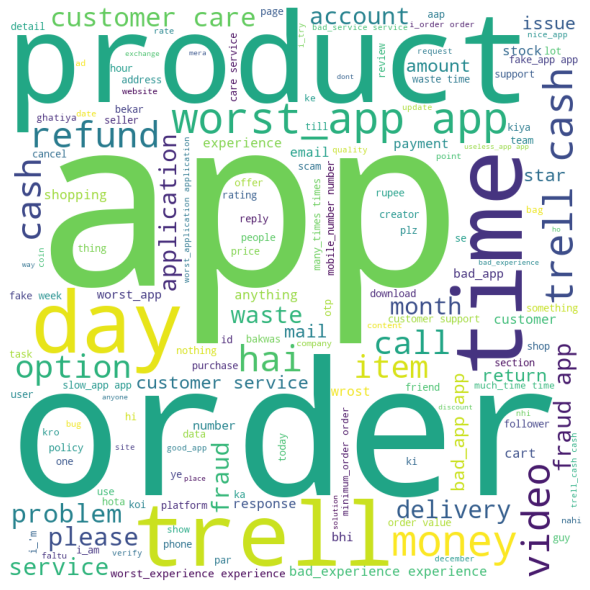

In [27]:
neg_cloud = ''
neg_cloud += " ".join(optimized_words)+" "
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(neg_cloud)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [28]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

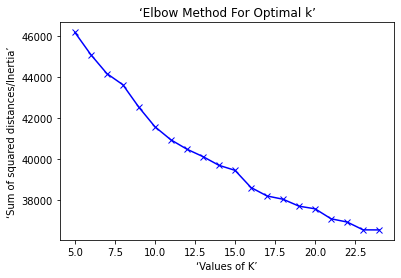

In [29]:
Sum_of_squared_distances = []
corpus_embeddings = embedder.encode(neg_reviews)
K = range(5,25)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(corpus_embeddings)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('‘Values of K’') 
plt.ylabel('‘Sum of squared distances/Inertia’') 
plt.title('‘Elbow Method For Optimal k’')
plt.show()

# Negative Cluster

In [30]:
neg_reviews[10]

"the one star is much enough for this useless app, in advertisement on facebook it claims about astrology but after that we can see it's a just useless life style app.. don't waste your time to download such poxy app"

In [37]:
df_all_columns_neg=df_all_columns_1[df_all_columns_1['sentiment']=='negative']
df_all_columns_pos=df_all_columns_1[df_all_columns_1['sentiment']=='positive']

df_all_columns_neg.iloc[10]['review_cleaned']

"the one star is much enough for this useless app, in advertisement on facebook it claims about astrology but after that we can see it's a just useless life style app.. don't waste your time to download such poxy app"

In [39]:
# Perform kmean clustering
num_clusters = 15
corpus_embeddings = embedder.encode(neg_reviews)
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(neg_reviews[sentence_id])

In [44]:
df_all_columns_neg['Cluster']=clustering_model.labels_+1
df_all_columns_pos['Cluster']=99
print(df_all_columns_neg['Cluster'].value_counts())

df_all_columns_neg.append(df_all_columns_pos).to_csv("/content/drive/My Drive/Colab Notebooks/All_columns_withCluster.csv",encoding='utf-16')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


2     241
4     233
15    189
6     159
1     154
11    143
5     117
8      87
9      72
7      65
3      62
10     62
12     57
13     53
14     21
Name: Cluster, dtype: int64


In [35]:
df_all_columns_neg.head()

,Package Name,App Version Code,App Version Name,Reviewer Language,Device,Review Submit Date and Time,Review Submit Millis Since Epoch,Review Last Update Date and Time,Review Last Update Millis Since Epoch,Star Rating,Review Title,Review Text,Developer Reply Date and Time,Developer Reply Millis Since Epoch,Developer Reply Text,Review Link,key,date,review_cleaned,sentiment,Cluster
5,app.trell,NaN,NaN,hi,RE50C1,2021-08-01T04:25:37Z,1627791937241,2021-08-01T04:25:37Z,1627791937241,1,NaN,Koi bi download mat karna bulkar bhi bhut ganda h,2021-08-01T05:26:00Z,1.627796e+12,"Hey Krishna, we are sorry to learn that you ha...",http://play.google.com/console/developers/8294...,6,Aug21,koi bi download mat karna bulkar bhi bhut ganda h,negative,0
12,app.trell,NaN,NaN,hi,a70q,2021-08-01T06:29:26Z,1627799366233,2021-08-01T06:29:26Z,1627799366233,1,NaN,क्यों बनाते हो ऐसा बेकार,2021-08-01T06:47:55Z,1.627800e+12,"Hello Amar, we are sad to know that your exper...",http://play.google.com/console/developers/8294...,13,Aug21,,negative,6
14,app.trell,6090.0,6.0.90,en,m51,2021-08-01T07:09:21Z,1627801761978,2021-08-01T07:09:21Z,1627801761978,1,NaN,Samsung gets paid to keep forcing this app to ...,2021-08-01T08:53:59Z,1.627808e+12,"Hi Vinith, we are sad to know that your experi...",http://play.google.com/console/developers/8294...,15,Aug21,samsung gets paid to keep forcing this app to ...,negative,10
34,app.trell,6090.0,6.0.90,en,RMX1901,2021-08-01T14:53:49Z,1627829629324,2021-08-01T14:53:49Z,1627829629324,1,NaN,only 2min deserve,2021-08-01T15:27:26Z,1.627832e+12,Sorry to know that you've had a bad experience...,http://play.google.com/console/developers/8294...,35,Aug21,only 2min deserve,negative,3
37,app.trell,6090.0,6.0.90,en,m31s,2021-08-01T16:13:59Z,1627834439474,2021-08-01T16:13:59Z,1627834439474,1,NaN,Bakwas app,2021-08-01T20:11:29Z,1.627849e+12,Sorry to know that you've had a bad experience...,http://play.google.com/console/developers/8294...,38,Aug21,bakwas app,negative,2


In [36]:
count = 0
for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    for j in range(len(cluster)):
      if count<1000: print(f"{j+1}.", cluster[j])
      count += 1
    print("\n\n\n")

print(count)

Cluster  1
1. koi bi download mat karna bulkar bhi bhut ganda h
2. (`) "hh
3. vikas .
4. ghatiya loser bat
5. uko
6. umbal app ever see in my life.......arum instal cheyaruthee.....
7. bakwass maha
8. bakwas
9. worst app..creators ko hire karte hai aur payment nahi dete ..payment dene me rula dete hai..3 months se payment nahi de rahe hai
10. whathapps
11. bakwas hai
12. bhai shop k liye maal lena h kya range padegi cosmatic ki
13. fdxxfxwww was aa s aai
14. pleaselog tcwew go.iubroglltcwew qhujplhlnpu, klmmt hv c ll mn b
15. download mat karna ye bewkuf banata hai
16. tamari mane chode 6 su ama lodav
17. bakvas
18. hhj
19. bhut hi bakwas app h kuch bhi order kro cancel kr dete h aur jo ponits milte h use bhi nhi dete cancel hone k baad mean ye fool bnate h trell points k naam pr .maine itni muskil se vo cash points collect liyethe inhone khud hi order cancel kiya aur points bhi kaat liye faltu mai worst app .kbhi download mt krna.
20. bakar
21. d. k v
22. h loughlin c he ng foust gee


In [ ]:
sss

# LDA

In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
stemmer = SnowballStemmer('english')
nltk.download('wordnet')

In [ ]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [ ]:
processed_docs = pd.Series(neg_reviews).map(preprocess)
processed_docs[:10]

# processed_docs=neg_reviews

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_docs)
# dictionary=neg_reviews

In [ ]:
# assume the word 'b' is to be deleted, put its id in a variable
del_ids = [k for k,v in dictionary.items() if v=='product' or v == 'good' or v == 'trell']

In [ ]:
# remove unwanted word ids from the dictionary in place
dictionary.filter_tokens(bad_ids=del_ids)

In [ ]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

In [ ]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=10000)

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
len(bow_corpus)

In [ ]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)

In [ ]:
corpus_tfidf = tfidf[bow_corpus]

In [ ]:
from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=8, id2word=dictionary, passes=2, workers=2)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=8, id2word=dictionary, passes=2, workers=4)

In [ ]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \nWord: {}'.format(idx, topic))

In [ ]:
test = ["delivery was late", "bad smell of perfume", "recieved damaged product", "recieved wrong product"]
for i in test:
  unseen_document = i
  bow_vector = dictionary.doc2bow(preprocess(unseen_document))
  print("\n", i, "\n")
  for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1])[:2]:
    #print("Score: {}\t Topic: {} \n".format(score, lda_model.print_topic(index, 5)))
    print("Topic: {} \n".format(lda_model.print_topic(index, 5)))

# BERTopic

In [ ]:
pip install 'numpy ==1.19.5' --force-reinstall

In [ ]:
import numpy as np

In [ ]:
negative = np.load('/content/drive/My Drive/Hotstart/neg.npy')


In [ ]:
len(negative)

In [ ]:
negative = [x.replace(' is', '').replace(' very', '').replace('trell', '').replace('op op', '').replace('op op op', '').replace('the', '').replace('it', '') for x in negative]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test = train_test_split(negative, test_size=0.1, random_state=42)

In [ ]:
len(X_train)

In [ ]:
%%capture
!pip install bertopic


In [ ]:
from bertopic import BERTopic

In [ ]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(X_train)

In [ ]:
freq = topic_model.get_topic_info(); freq.head(20)

In [ ]:
topic_model.get_topic(0) 

In [ ]:
topic_model.update_topics(X_train, topics, n_gram_range=(1, 4))

In [ ]:
topic_model.visualize_barchart(top_n_topics=15)

In [ ]:
new_topics, new_probs = topic_model.reduce_topics(X_train, topics, probs, nr_topics=9)

In [ ]:
# Save model
topic_model.save("/content/drive/My Drive/Hotstart/BERTopic_model")

In [ ]:
sss

In [ ]:
len(X_test)

In [ ]:
model_preds = []
for i in X_test:
  preds = topic_model.transform([i])
  max_value = max(list(preds[1][0]))
  pred = list(preds[1][0]).index(max_value)
  max_value = max(list(preds[1][0]))
  pred = list(preds[1][0]).index(max_value)
  print(i)
  predictions = topic_model.get_topic(pred) 
  s = ''
  for p in predictions[:5]:
    s = s + p[0] + " "
  model_preds.append(s)

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(list(zip(X_test, model_preds)),
               columns =['review', 'pred'])

In [ ]:
df

In [ ]:
X_train_1=pd.DataFrame(X_train)
X_train_1.columns=['Review']
X_train_1.head()

In [ ]:
import spacy # (I have version 1.8.2)
nlp = spacy.load('en')
X_train_2 = X_train_1['Review'].apply(nlp)

In [ ]:
!pip install git+https://github.com/LIAAD/yake

In [ ]:
import yake
kw_extractor = yake.KeywordExtractor()
text=X_train_2
language = "en"
max_ngram_size = 3
deduplication_threshold = 0.9
numOfKeywords = 20
custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
keywords = custom_kw_extractor.extract_keywords(text)
for kw in keywords:
     print(kw)


In [ ]:
!pip install rake-nltk
import nltk
nltk.download('stopwords')

In [ ]:
from rake_nltk import Rake

In [ ]:
r = Rake()    
df=X_train_1
def rake_implement(x,r):
     r.extract_keywords_from_text(x)
     return r.get_ranked_phrases()

df['new_col'] =df['Review'].apply(lambda x: rake_implement(x,r))
print(df['new_col'])
